In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number__images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number__images):
    print(f"Collecting images {imgnum}")
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [3]:
!labelme

^C


In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [7]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [8]:
images.as_numpy_iterator().next()

b'data\\images\\12276a17-1eb4-11ef-97f9-3003c838d5ca.jpg'

In [9]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[75, 74, 72],
        [75, 74, 72],
        [74, 73, 71],
        ...,
        [63, 63, 63],
        [61, 61, 61],
        [60, 60, 60]],

       [[75, 74, 72],
        [75, 74, 72],
        [74, 73, 71],
        ...,
        [63, 63, 63],
        [61, 61, 61],
        [60, 60, 60]],

       [[75, 74, 72],
        [75, 74, 72],
        [74, 73, 71],
        ...,
        [63, 63, 63],
        [62, 62, 62],
        [61, 61, 61]],

       ...,

       [[71, 73, 70],
        [73, 75, 72],
        [73, 75, 72],
        ...,
        [71, 71, 73],
        [71, 71, 73],
        [70, 70, 72]],

       [[72, 74, 69],
        [73, 75, 70],
        [73, 75, 70],
        ...,
        [70, 70, 72],
        [70, 70, 72],
        [69, 69, 71]],

       [[72, 74, 69],
        [73, 75, 70],
        [73, 75, 70],
        ...,
        [70, 70, 72],
        [69, 69, 71],
        [69, 69, 71]]], dtype=uint8)

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

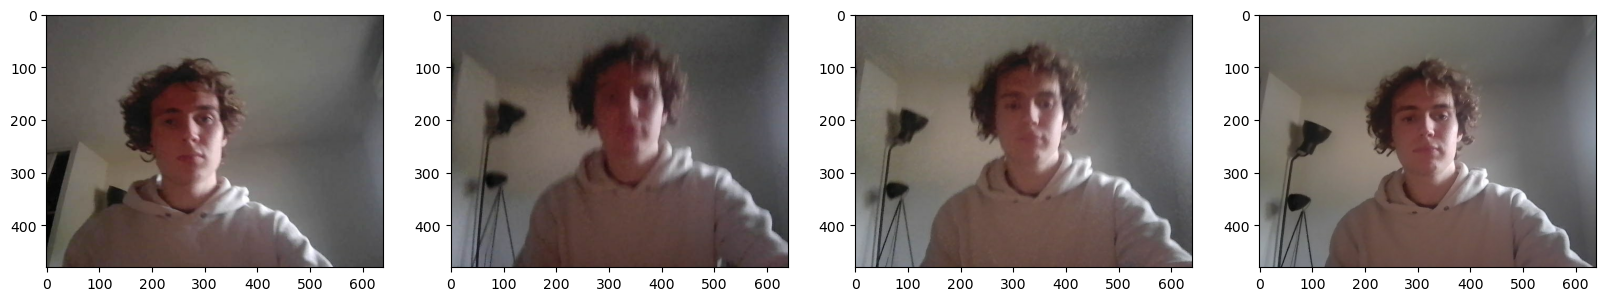

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [3]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [4]:
import albumentations as alb

In [5]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [6]:
img = cv2.imread(os.path.join('data', 'train', 'images', '51f09077-1eb5-11ef-b93f-3003c838d5ca.jpg'))

In [8]:
with open(os.path.join('data', 'train', 'labels', '51f09077-1eb5-11ef-b93f-3003c838d5ca.json'), 'r') as f:
    label = json.load(f)

In [14]:
label['shapes'][0]['points']

[[243.5294117647059, 96.37254901960785],
 [474.90196078431376, 330.359477124183]]

In [15]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
coords

[243.5294117647059, 96.37254901960785, 474.90196078431376, 330.359477124183]

In [17]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [18]:
coords

[0.380514705882353,
 0.20077614379084968,
 0.7420343137254902,
 0.6882489106753813]

In [19]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['faces'])

In [22]:
augmented['bboxes']

[(0.3389542483660131,
  0.2052723311546841,
  0.8531154684095861,
  0.7252432824981845)]

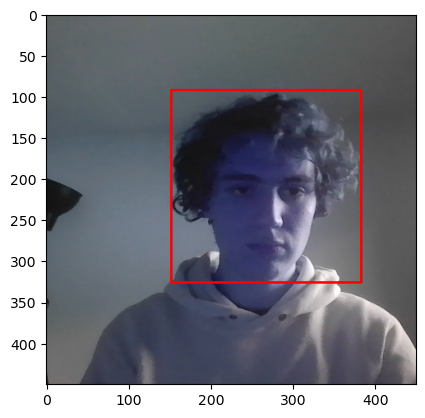

In [24]:
cv2.rectangle(
    augmented['image'],
    tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
    (255, 0, 0), 2
)

plt.imshow(augmented['image'])